In [2]:
import logging

import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf

from utils.load_dataset import load_dataset

tf.get_logger().setLevel(logging.ERROR)
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, True)

Загрузим данные, разбив на тренировочную, валидационную и тестовую выборки:

In [4]:
train_ds, val_ds, test_ds = load_dataset(os.path.abspath('images'))

Found 19794 files belonging to 40 classes.
Using 13856 files for training.
Found 19794 files belonging to 40 classes.
Using 5938 files for validation.



Загрузим базовую модель NASNetMobile без верхних слоев:

In [5]:
base_model = tf.keras.applications.NASNetMobile(input_shape=(256, 256, 3),
                                                include_top=False,
                                                weights='imagenet')

Заморозим слои, чтобы веса не обновлялись во время обучения:

In [6]:
base_model.trainable = False

Определим архитектуру нашей модели:

In [7]:
inputs = tf.keras.Input(shape=(256, 256, 3))
preprocess =  tf.keras.layers.Rescaling(1./255)(inputs)
x = base_model(preprocess, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.Dense(512, activation='relu')(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = tf.keras.layers.Dense(40, activation='softmax')(x)
model = tf.keras.Model(inputs, outputs)

In [8]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling (Rescaling)           │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ NASNet (Functional)             │ (None, 8, 8, 1056)     │     4,269,716 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1056)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1056)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │       541,184 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 40)             │        20,520 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,831,420 (18.43 MB)

 Trainable params: 561,704 (2.14 MB)

 Non-trainable params: 4,269,716 (16.29 MB)

Начнем обучение модели с замороженными нижними слоями:

In [9]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=['accuracy'])

Определим наши коллбэк-функции:

In [10]:
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(
    "my_checkpoints/nas_net_mobile.weights.h5",
    save_weights_only=True)

es = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy',
    min_delta=0,
    patience=2,
    verbose=0,
    mode='auto',
    baseline=None,
    restore_best_weights=True,
    start_from_epoch=0
)

In [11]:
%%time
history_1 = model.fit(train_ds,
                      epochs=20,
                      validation_data=val_ds,
                      callbacks=[checkpoint_cb, es])

Epoch 1/20


I0000 00:00:1713941468.787527   90484 service.cc:145] XLA service 0x762d3c22eae0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1713941468.787562   90484 service.cc:153]   StreamExecutor device (0): NVIDIA GeForce GTX 1070, Compute Capability 6.1
2024-04-24 13:51:09.265359: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-04-24 13:51:12.397347: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8907


  2/433 ━━━━━━━━━━━━━━━━━━━━ 37s 86ms/step - accuracy: 0.0391 - loss: 3.6981   

I0000 00:00:1713941481.432534   90484 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'input_concatenate_fusion_1', 4 bytes spill stores, 4 bytes spill loads

I0000 00:00:1713941481.451289   90484 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


433/433 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - accuracy: 0.1774 - loss: 3.2095

I0000 00:00:1713941527.377810   90490 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'input_concatenate_fusion', 4 bytes spill stores, 4 bytes spill loads

I0000 00:00:1713941541.102002   90489 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'input_concatenate_fusion', 4 bytes spill stores, 4 bytes spill loads



433/433 ━━━━━━━━━━━━━━━━━━━━ 88s 141ms/step - accuracy: 0.1776 - loss: 3.2085 - val_accuracy: 0.4483 - val_loss: 2.0714
Epoch 2/20
433/433 ━━━━━━━━━━━━━━━━━━━━ 46s 105ms/step - accuracy: 0.4381 - loss: 2.0398 - val_accuracy: 0.5294 - val_loss: 1.7187
Epoch 3/20
433/433 ━━━━━━━━━━━━━━━━━━━━ 45s 104ms/step - accuracy: 0.5063 - loss: 1.7471 - val_accuracy: 0.5608 - val_loss: 1.5546
Epoch 4/20
433/433 ━━━━━━━━━━━━━━━━━━━━ 46s 105ms/step - accuracy: 0.5463 - loss: 1.5947 - val_accuracy: 0.5834 - val_loss: 1.4695
Epoch 5/20
433/433 ━━━━━━━━━━━━━━━━━━━━ 45s 104ms/step - accuracy: 0.5755 - loss: 1.4771 - val_accuracy: 0.5982 - val_loss: 1.3981
Epoch 6/20
433/433 ━━━━━━━━━━━━━━━━━━━━ 45s 102ms/step - accuracy: 0.5985 - loss: 1.3965 - val_accuracy: 0.6172 - val_loss: 1.3554
Epoch 7/20
433/433 ━━━━━━━━━━━━━━━━━━━━ 45s 103ms/step - accuracy: 0.6109 - loss: 1.3540 - val_accuracy: 0.6199 - val_loss: 1.3115
Epoch 8/20
433/433 ━━━━━━━━━━━━━━━━━━━━ 46s 106ms/step - accuracy: 0.6203 - loss: 1.2962 - val

Так как число параметров в нижних слоях огромно (более 20 миллионов), то мы не будем размораживать \
нижние слои для тренировки в силу ограниченных вычислительных мощностей.

In [12]:
results = model.evaluate(test_ds)

93/93 ━━━━━━━━━━━━━━━━━━━━ 8s 77ms/step - accuracy: 0.6816 - loss: 1.0899


In [13]:
results

[1.103249430656433, 0.6780914068222046]

Посмотрим несколько предсказаний:

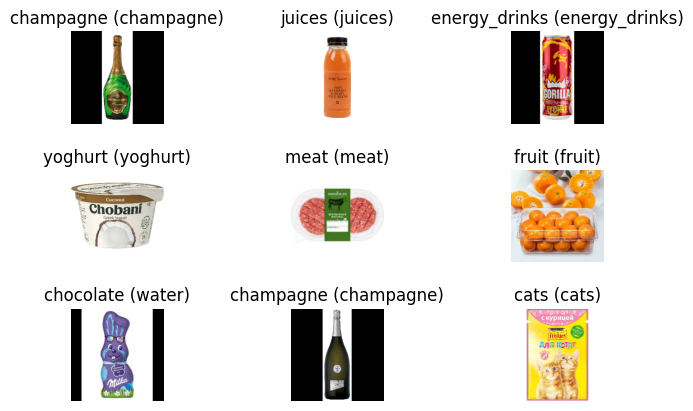

In [14]:
class_names = train_ds.class_names
IMAGE_NUM = 2
for i, (images, labels) in enumerate(test_ds):
    if i == 9:
        break
    ax = plt.subplot(3, 3, i + 1)
    im = np.expand_dims(images[IMAGE_NUM].numpy(), axis=0)
    prediction = class_names[np.argmax(model.predict(im, verbose=0)[0])]
    plt.imshow(images[IMAGE_NUM, ...].numpy().astype("uint8"))
    plt.title(class_names[np.argmax(labels.numpy()[IMAGE_NUM])] + f' ({prediction})')
    plt.axis("off")
    plt.subplots_adjust(left=None, bottom=None, right=1.1, top=None, wspace=None, hspace=0.5)


I0000 00:00:1713942950.221918   90489 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'input_concatenate_fusion', 4 bytes spill stores, 4 bytes spill loads

2024-04-24 14:16:01.667002: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


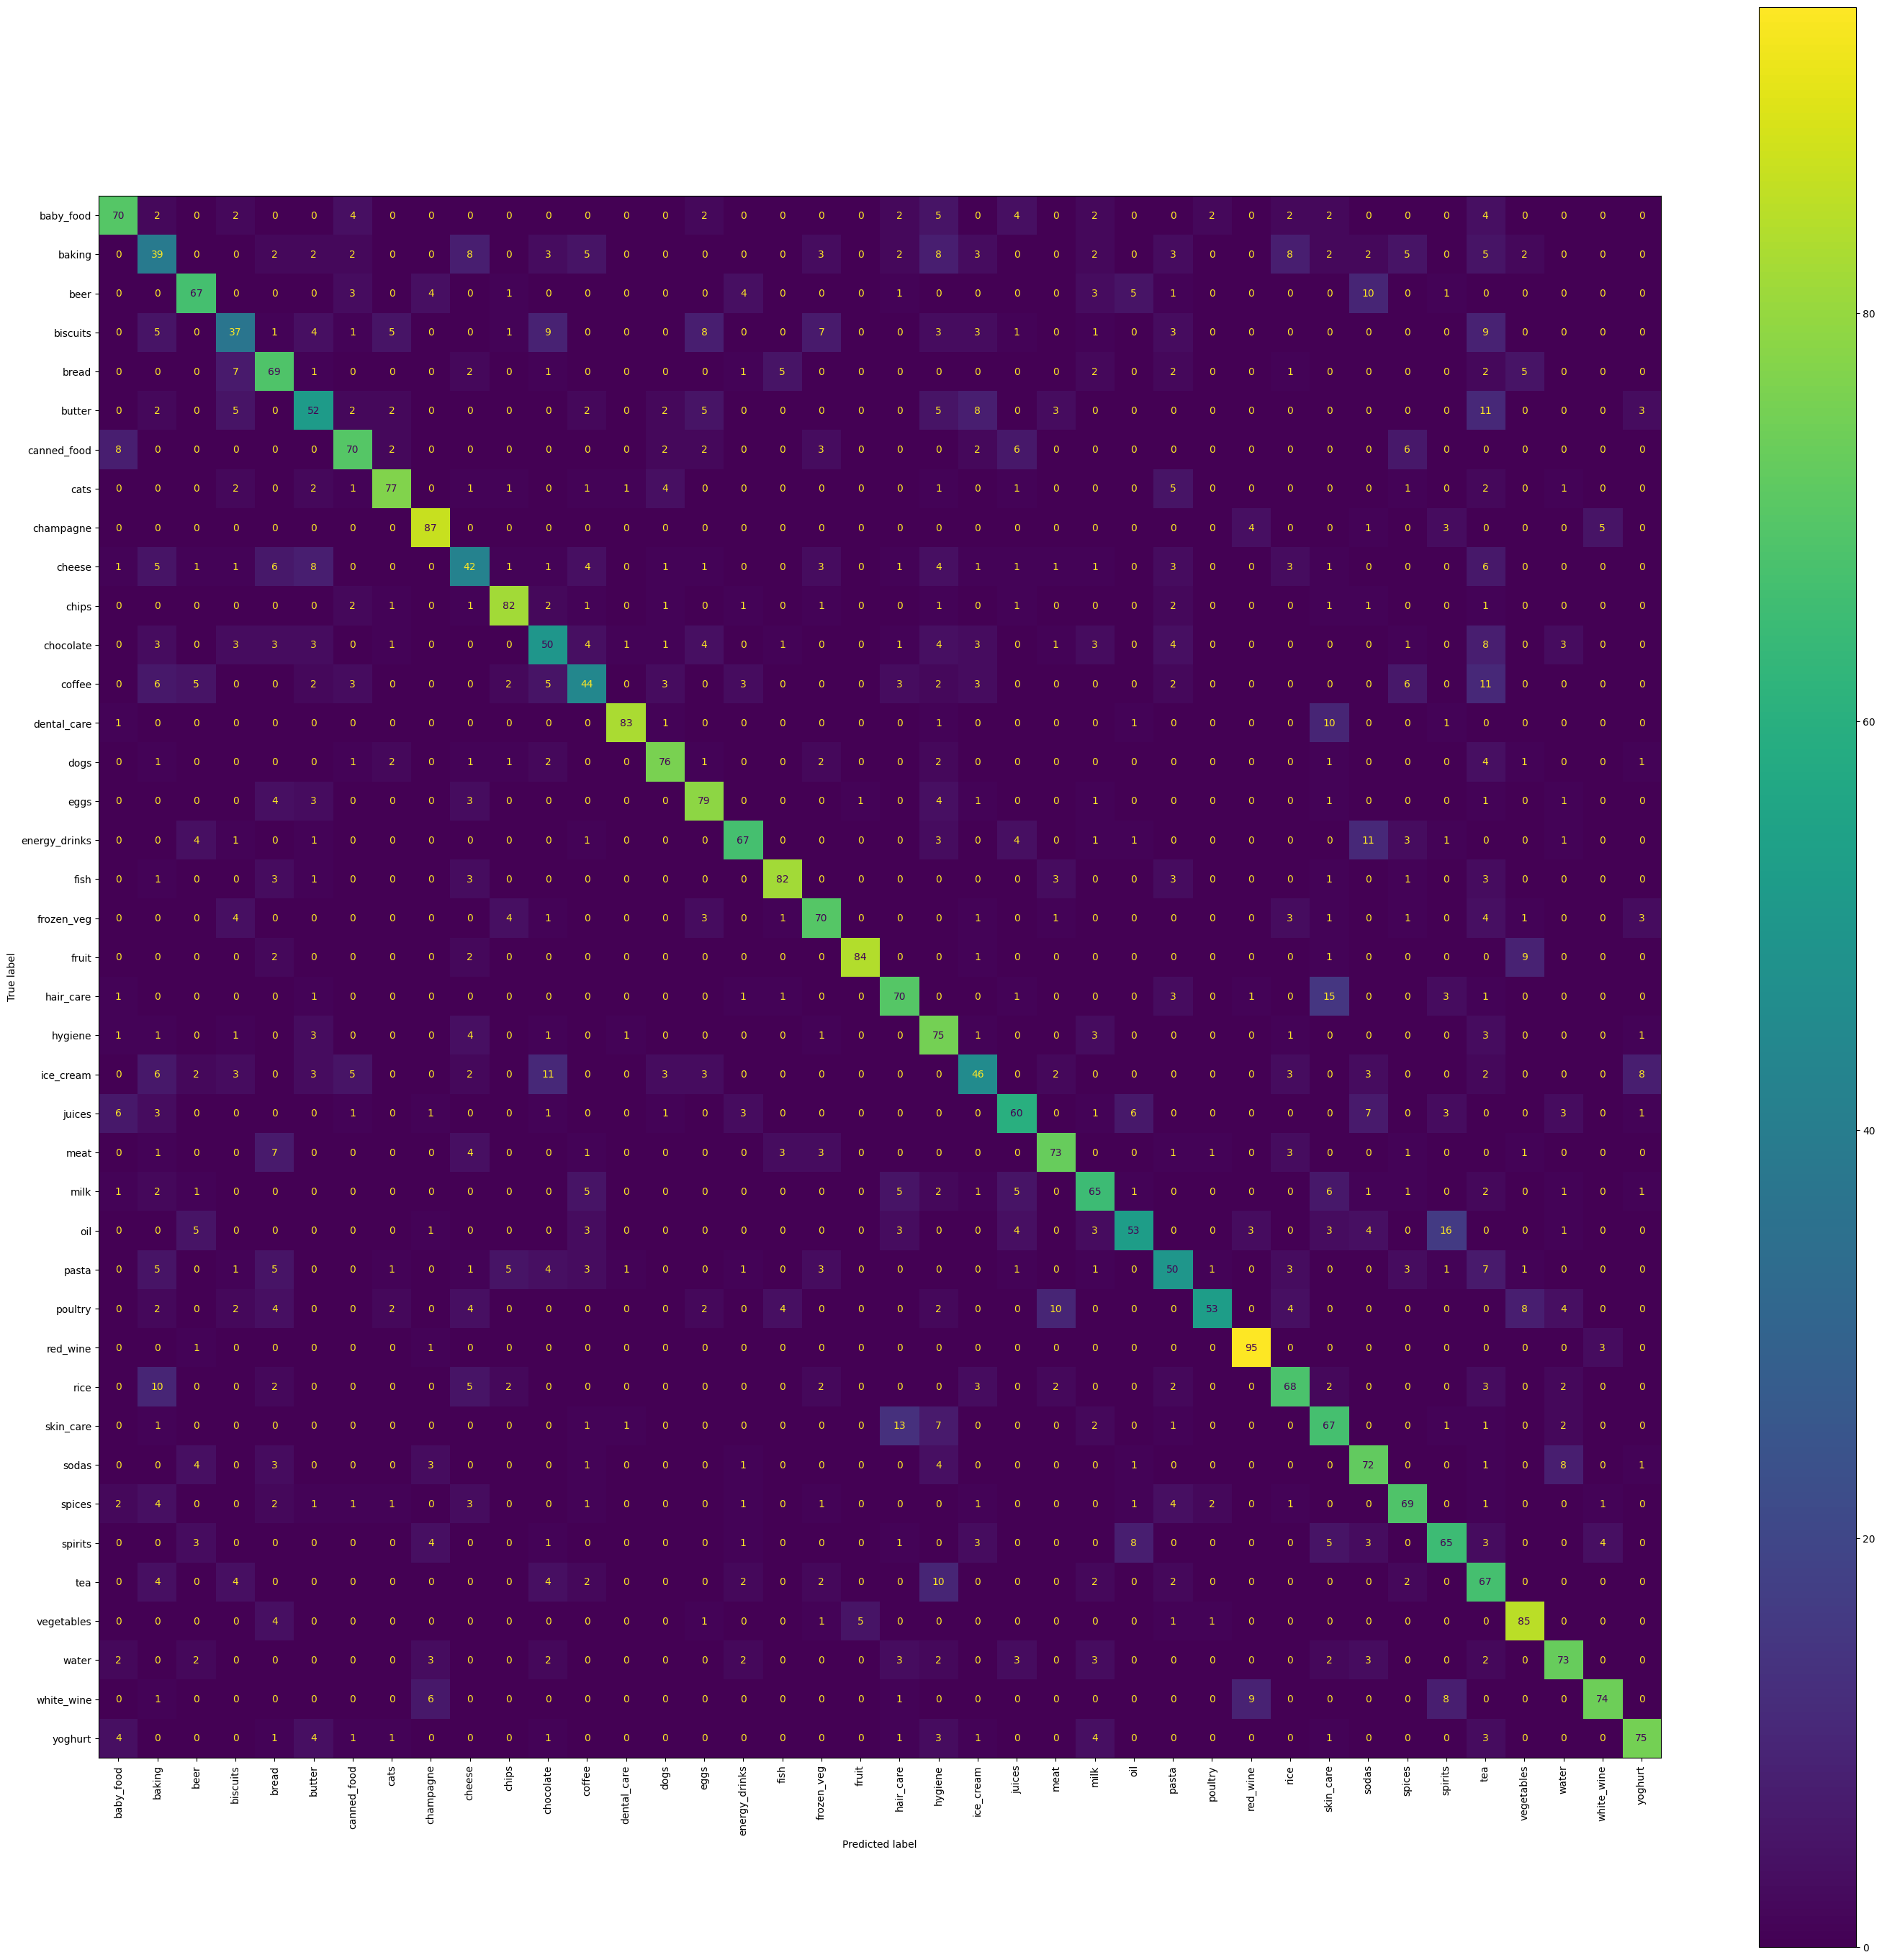

In [15]:
from utils.confusion_matrix import plot_confusion_matrix

plot_confusion_matrix(model, test_ds, train_ds.class_names)

In [16]:
model.save('ready_models/nas_net_mobile.keras')

In [17]:
import json

with open('models_histories/nas_net_mobile.json', 'w') as f:
    json.dump(history_1.history, f, indent=4)

Text(0, 0.5, 'Валидационная точность')

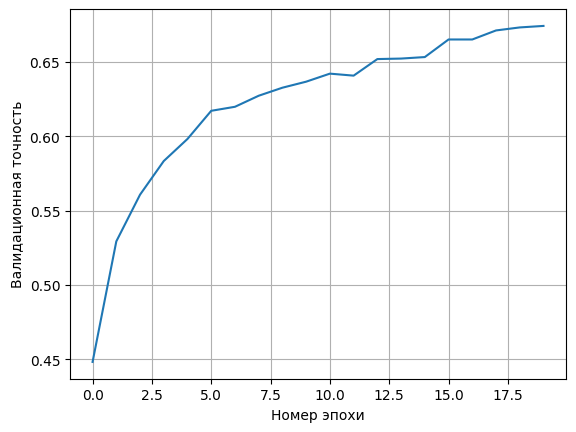

In [18]:
plt.plot(range(len(history_1.history['accuracy'])), history_1.history['val_accuracy'])
plt.grid()
plt.xlabel('Номер эпохи')
plt.ylabel('Валидационная точность')